
The raw dataset is here:  
https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023

And the folder with all the product datasets is here:  
https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023/tree/main/raw/meta_categories



In [14]:
# imports

import os
import random
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import load_dataset, Dataset, DatasetDict
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import numpy as np
import pickle

In [15]:
# environment

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [16]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [1]:
# More imports after HF login

from loaders import ItemLoader
from items import Item

In [2]:
%matplotlib inline


Let's look at all datasets of all the items that you might find in a large home retail store - electrical, electronic, office and related, but not clothes / beauty / books.

In [3]:
dataset_names = [
    "Automotive",
    "Electronics",
    "Appliances",
]

In [4]:
items = []
for dataset_name in dataset_names:
    loader = ItemLoader(dataset_name)
    items.extend(loader.load())

# Now, time for a coffee break!!
# By the way, I put the biggest datasets first.. it gets faster.

Loading dataset Automotive


`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'McAuley-Lab/Amazon-Reviews-2023' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.
Using the latest cached version of the dataset since McAuley-Lab/Amazon-Reviews-2023 couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'raw_meta_Automotive' at /Users/ali.shamsaddinlou/.cache/huggingface/datasets/McAuley-Lab___amazon-reviews-2023/raw_meta_Automotive/0.0.0/16b76e0823d73bb8cff1e9c5e3e37dbc46ae3daee380417ae141f5e67d3ea8e8 (last modified on Mon Jul 14 11:58:13 2025).
100%|██████████| 2004/2004 [03:21<00:00,  9.96it/s]


Completed Automotive with 911,688 datapoints in 3.5 mins
Loading dataset Electronics


`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'McAuley-Lab/Amazon-Reviews-2023' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.
Using the latest cached version of the dataset since McAuley-Lab/Amazon-Reviews-2023 couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'raw_meta_Electronics' at /Users/ali.shamsaddinlou/.cache/huggingface/datasets/McAuley-Lab___amazon-reviews-2023/raw_meta_Electronics/0.0.0/16b76e0823d73bb8cff1e9c5e3e37dbc46ae3daee380417ae141f5e67d3ea8e8 (last modified on Mon Jul 14 12:05:24 2025).
100%|██████████| 1611/1611 [02:02<00:00, 13.13it/s]


Completed Electronics with 443,473 datapoints in 2.2 mins
Loading dataset Appliances


`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'McAuley-Lab/Amazon-Reviews-2023' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.
Using the latest cached version of the dataset since McAuley-Lab/Amazon-Reviews-2023 couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'raw_meta_Appliances' at /Users/ali.shamsaddinlou/.cache/huggingface/datasets/McAuley-Lab___amazon-reviews-2023/raw_meta_Appliances/0.0.0/16b76e0823d73bb8cff1e9c5e3e37dbc46ae3daee380417ae141f5e67d3ea8e8 (last modified on Wed Jul  9 09:25:09 2025).
100%|██████████| 95/95 [00:18<00:00,  5.05it/s]


Completed Appliances with 28,625 datapoints in 0.3 mins


In [5]:
print(f"A grand total of {len(items):,} items")

A grand total of 1,383,786 items


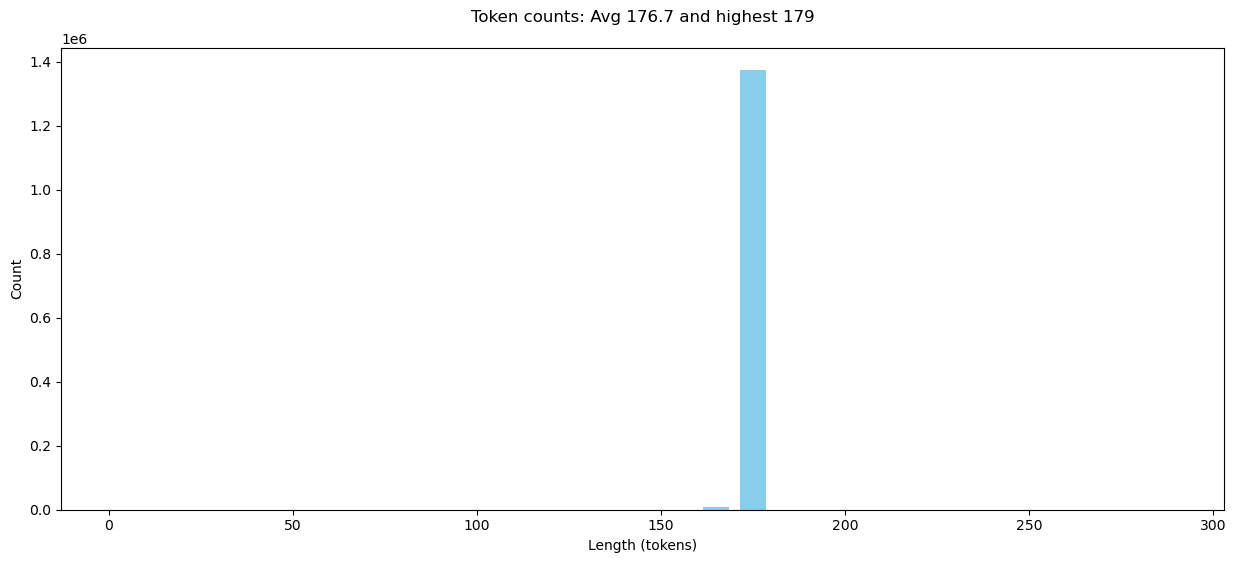

In [9]:
# Plot the distribution of token counts again
import matplotlib.pyplot as plt
tokens = [item.token_count for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Token counts: Avg {sum(tokens)/len(tokens):,.1f} and highest {max(tokens):,}\n")
plt.xlabel('Length (tokens)')
plt.ylabel('Count')
plt.hist(tokens, rwidth=0.7, color="skyblue", bins=range(0, 300, 10))
plt.show()

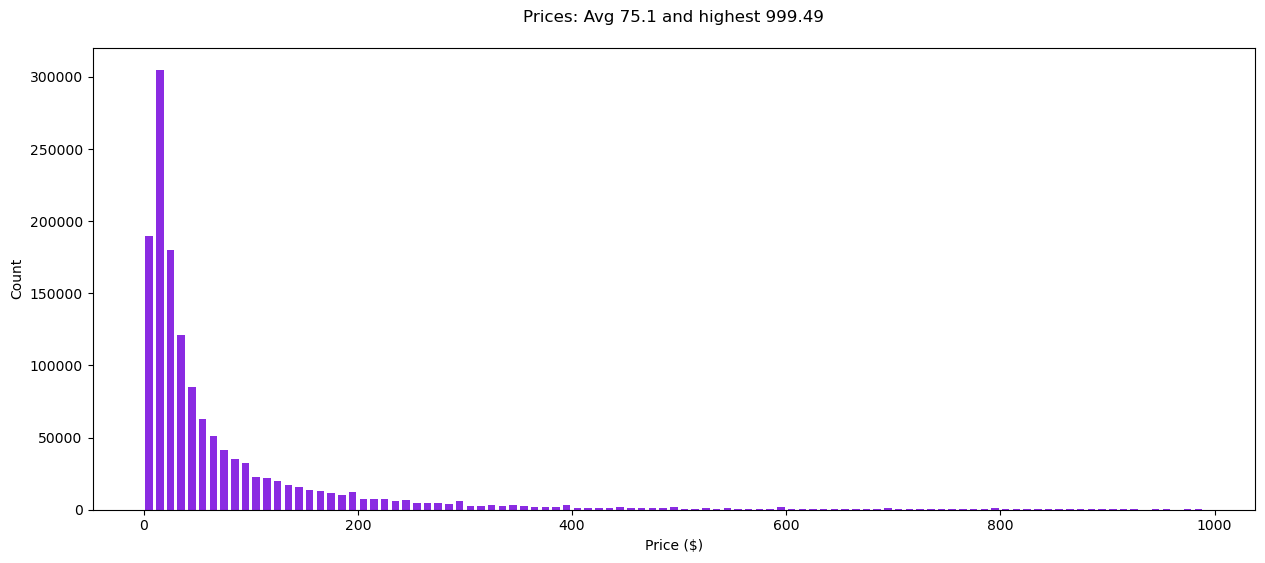

In [10]:
# Plot the distribution of prices

prices = [item.price for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.1f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="blueviolet", bins=range(0, 1000, 10))
plt.show()

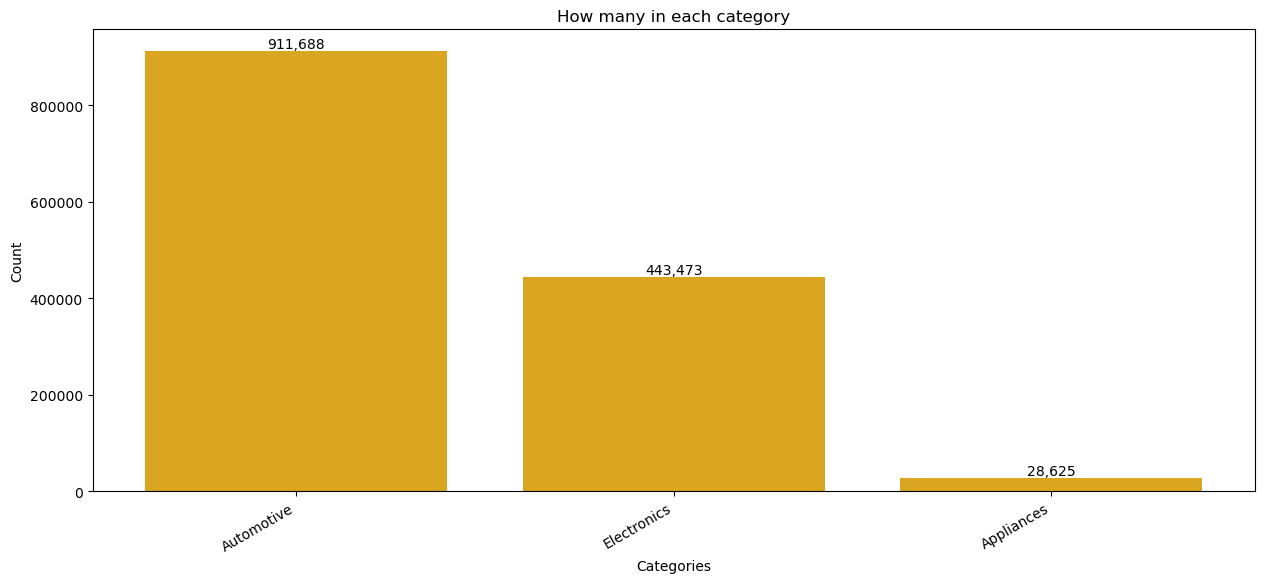

In [12]:
from collections import Counter, defaultdict

category_counts = Counter()
for item in items:
    category_counts[item.category]+=1

categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

# Bar chart by category
plt.figure(figsize=(15, 6))
plt.bar(categories, counts, color="goldenrod")
plt.title('How many in each category')
plt.xlabel('Categories')
plt.ylabel('Count')

plt.xticks(rotation=30, ha='right')

# Add value labels on top of each bar
for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha='center', va='bottom')

# Display the chart
plt.show()

# Objective

Craft a dataset which is more balanced in terms of prices. Less heavily scewed to cheap items, with an average that's higher than $60. Try to balance out the categories - fewer Automotive items.

In [17]:
# Create a dict with a key of each price from $1 to $999
# And in the value, put a list of items with that price (to nearest round number)

slots = defaultdict(list)
for item in items:
    slots[round(item.price)].append(item)

In [18]:
# Create a dataset called "sample" which tries to more evenly take from the range of prices
# And gives more weight to items from categories other than Automotive
# Set random seed for reproducibility

np.random.seed(42)
random.seed(42)
sample = []
for i in range(1, 1000):
    slot = slots[i]
    if i>=240:
        sample.extend(slot)
    elif len(slot) <= 1200:
        sample.extend(slot)
    else:
        weights = np.array([1 if item.category=='Automotive' else 5 for item in slot])
        weights = weights / np.sum(weights)
        selected_indices = np.random.choice(len(slot), size=1200, replace=False, p=weights)
        selected = [slot[i] for i in selected_indices]
        sample.extend(selected)

print(f"There are {len(sample):,} items in the sample")

There are 343,528 items in the sample


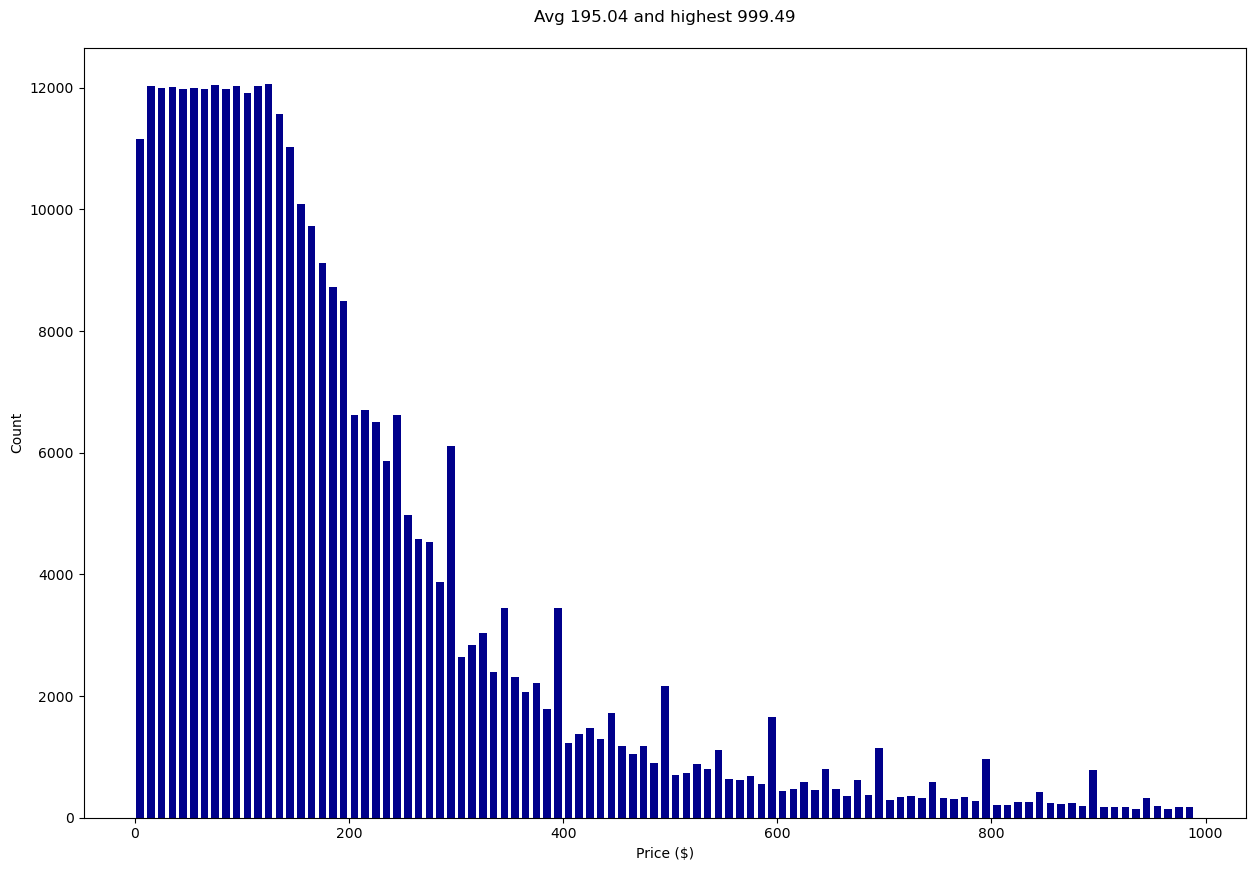

In [19]:
# Plot the distribution of prices in sample

prices = [float(item.price) for item in sample]
plt.figure(figsize=(15, 10))
plt.title(f"Avg {sum(prices)/len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 10))
plt.show()

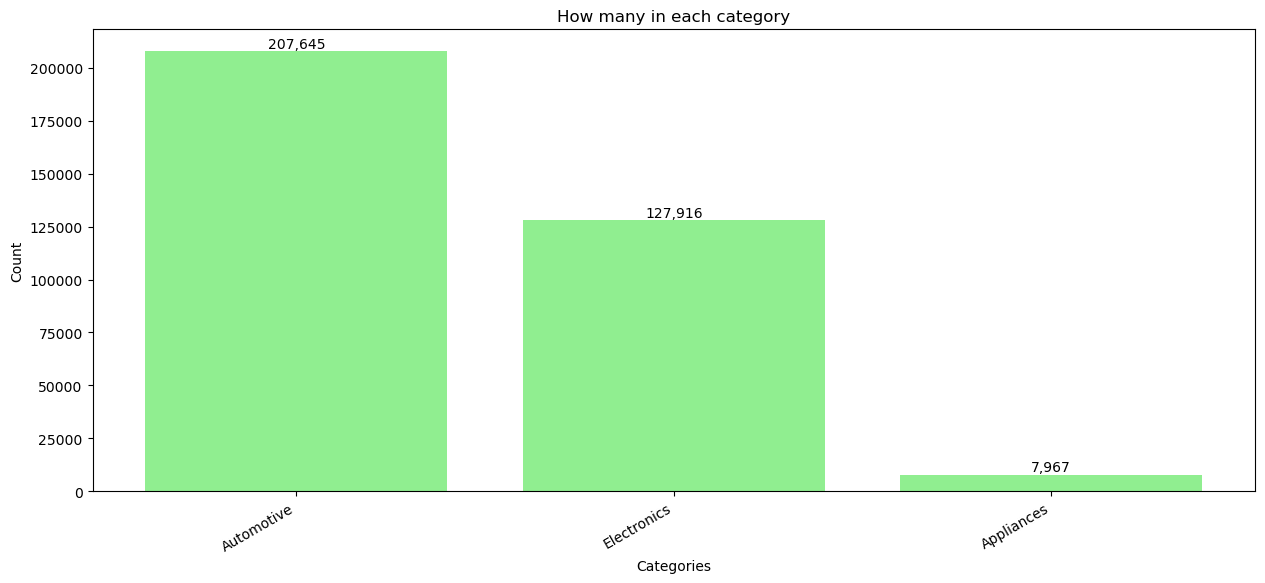

In [20]:
# OK, we did well in terms of raising the average price and having a smooth-ish population of prices
# Let's see the categories

category_counts = Counter()
for item in sample:
    category_counts[item.category]+=1

categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

# Create bar chart
plt.figure(figsize=(15, 6))
plt.bar(categories, counts, color="lightgreen")

# Customize the chart
plt.title('How many in each category')
plt.xlabel('Categories')
plt.ylabel('Count')

plt.xticks(rotation=30, ha='right')

# Add value labels on top of each bar
for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha='center', va='bottom')

# Display the chart
plt.show()

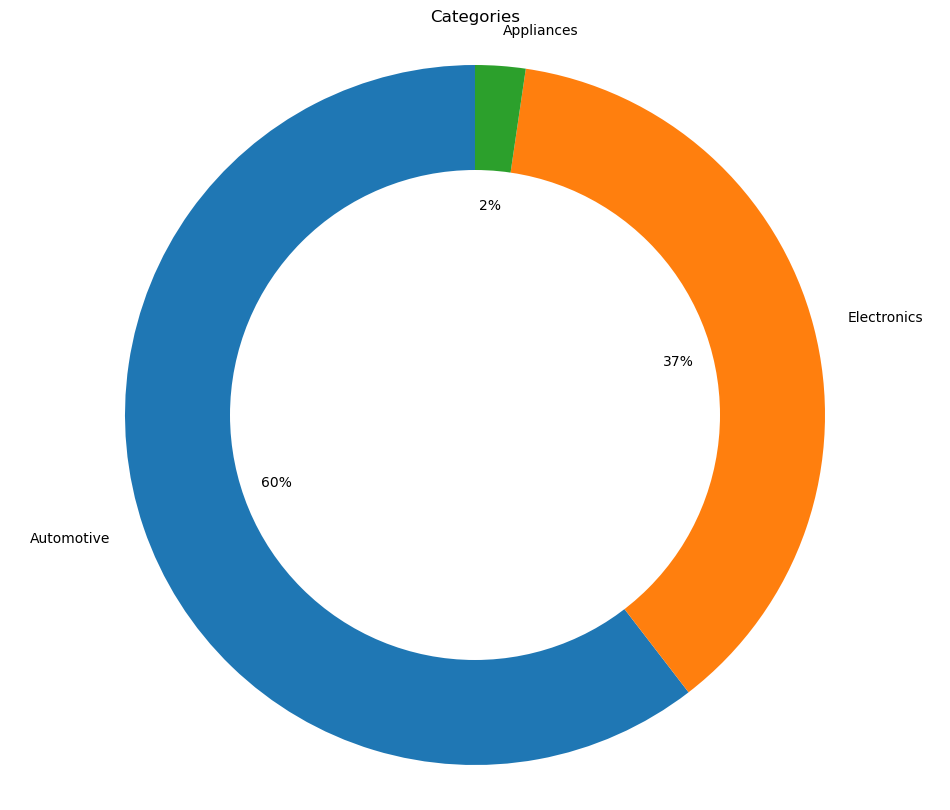

In [21]:
# Automotive still in the lead, but improved somewhat
# For another perspective, let's look at a pie

plt.figure(figsize=(12, 10))
plt.pie(counts, labels=categories, autopct='%1.0f%%', startangle=90)

# Add a circle at the center to create a donut chart (optional)
centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Categories')

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')  

plt.show()

# Dataset Curated!

We've crafted an excellent dataset.

Let's do some final checks

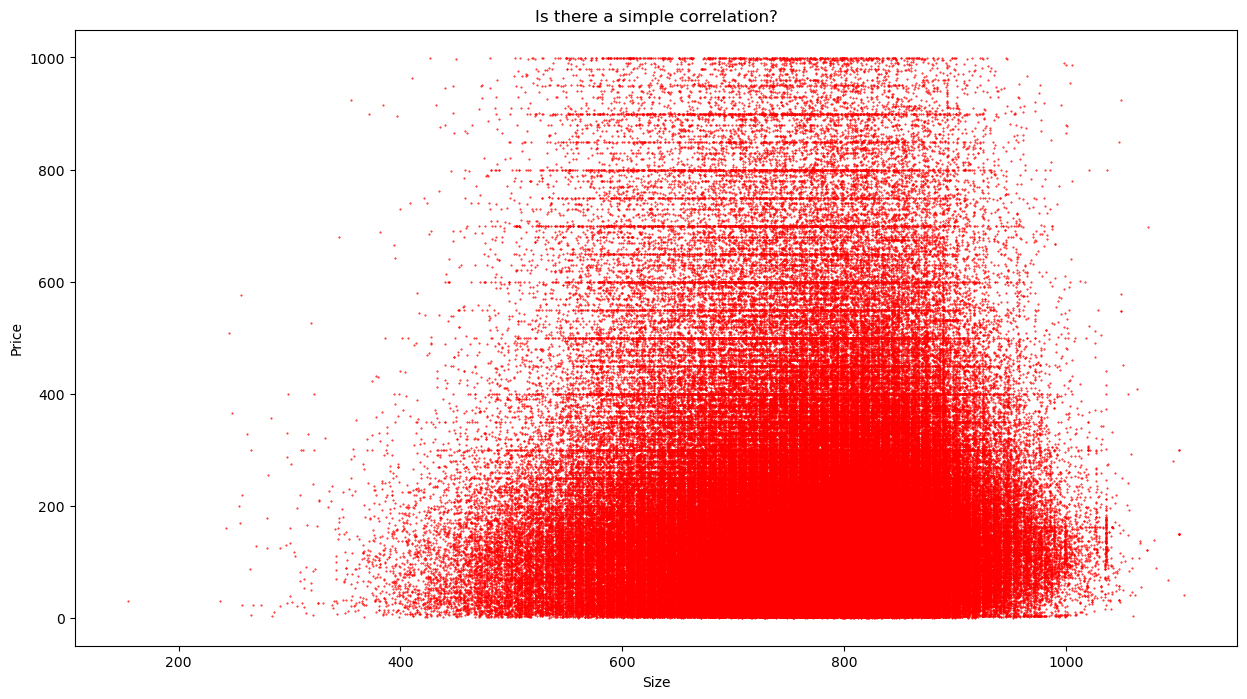

In [22]:
# How does the price vary with the character count of the prompt?

sizes = [len(item.prompt) for item in sample]
prices = [item.price for item in sample]

# Create the scatter plot
plt.figure(figsize=(15, 8))
plt.scatter(sizes, prices, s=0.2, color="red")

# Add labels and title
plt.xlabel('Size')
plt.ylabel('Price')
plt.title('Is there a simple correlation?')

# Display the plot
plt.show()

In [23]:
def report(item):
    prompt = item.prompt
    tokens = Item.tokenizer.encode(item.prompt)
    print(prompt)
    print(tokens[-10:])
    print(Item.tokenizer.batch_decode(tokens[-10:]))

In [24]:
report(sample[38000])

How much does this cost to the nearest dollar?

Door Shelf Basket Bin, Suitable for Refrigerator Refrigerator Door Bin Guard Assembly, Part number
Suitable for Refrigerator Refrigerator Door Bin Guard Assembly Replace Compatible with Samsung refrigerators. ❅Compatible models If your refrigerator model is not among the above models, you will not be suitable to buy this product. ❅Why choose us Made of strong materials, durable. Perfect for your refrigerator. ❅Note This model of refrigerator door bins can only be installed in the middle of the refrigerator door, not suitable for installation in the lower part of the refrigerator door. Please do not close the refrigerator door by pulling the refrigerator bins. ❅After-sales service We have perfect pre-sales and after-sales service. Can solve any of your questions about the product. Manufacturer Ebusin, Part Ebusin

Price is $33.00
[469, 10551, 258, 271, 7117, 374, 400, 1644, 13, 410]
[' E', 'bus', 'in', '\n\n', 'Price', ' is', ' $', '33', '

## Observation

An interesting thing about the Llama tokenizer is that every number from 1 to 999 gets mapped to 1 token, much as we saw with gpt-4o. The same is not true of qwen2, gemma and phi3, which all map individual digits to tokens. This does turn out to be a bit useful for our project, although it's not an essential requirement.

# Finally

It's time to break down our data into a training, test and validation dataset.

It's typical to use 5%-10% of your data for testing purposes, but actually we have far more than we need at this point. We'll take 400,000 points for training, and we'll reserve 2,000 for testing, although we won't use all of them.


In [25]:
random.seed(42)
random.shuffle(sample)
train = sample[:300_000]
test = sample[300_000:340_000]
print(f"Divided into a training set of {len(train):,} items and test set of {len(test):,} items")

Divided into a training set of 300,000 items and test set of 40,000 items


In [26]:
print(train[0].prompt)

How much does this cost to the nearest dollar?

Mennon DC-sn 62 Improved Screw Mount 62mm Flower Lens Hood with Cap, Black
The main function of the lens hood is to shade the lens from stray light, improving your contrast and image quality. But it will also protects the front barrel from the inevitable impacts against walls, door frames, and other real-life obstacles and in inclement weather, it can assist in keeping moisture or wind-blown debris off the lens. The advantage of the petal shape design is, that it offers the same prevention of flare as the corresponding circular or rectangular design, but with a smaller size and a lighter weight. Installation * Rotate lock-ring to expose the thread's mounting thread * Attach the hood by screwing it on the filter or lens thread. * Rotate lock-ring back to fix the hood on

Price is $9.00


In [27]:
print(test[0].test_prompt())

How much does this cost to the nearest dollar?

Can-Am Commander Maverick Soft Rear Window Deflector Clear Max
Fits Commander MAX 2014 & upMaverick MAX 2014 & up New OEM Can-Am Coupe Vent Ar. Clear Deflector OEM Part Number (QTY 1) Item only fits specific models listed. The picture could be generic. Message us with VIN/HULL for fast fitment verification. Color Clear, Brand Can-Am, Exterior Finish Chrome, Style Classic, Auto Part Position Rear, Vehicle Service Type Car, Fit Type Vehicle Specific Fit, Pieces 1, Installation Type Window, Manufacturer Can-Am Accessories, Dimensions 43 x 5 x 5 inches, Manufacturer Part OEM Part Rank Automotive Rear Window Wind Deflectors 150, Available December 29, 2016

Price is $


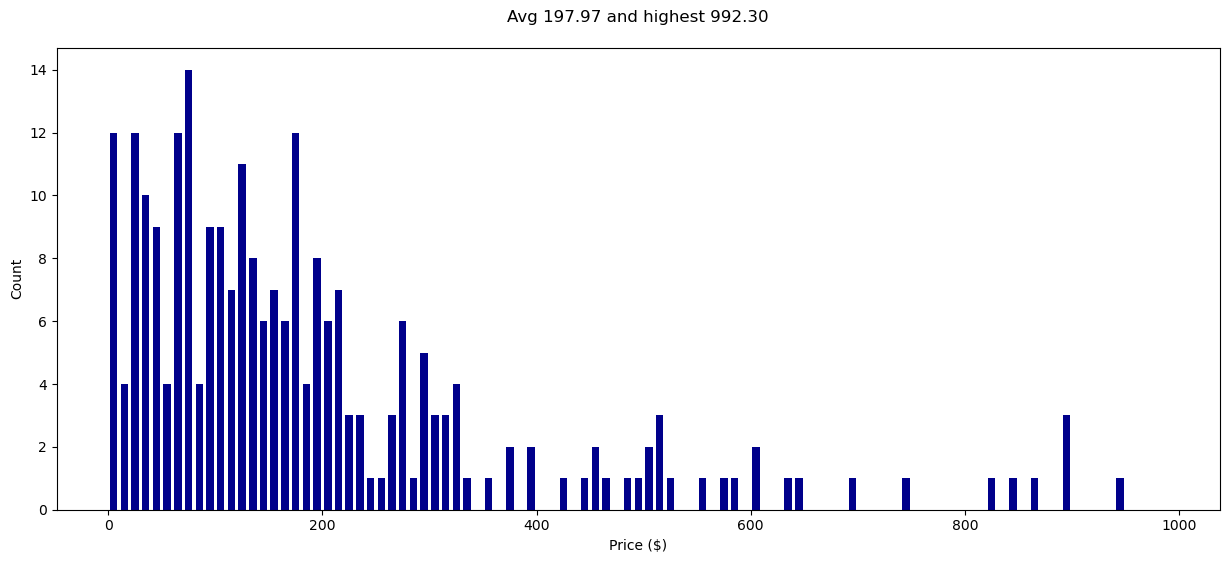

In [28]:
# Plot the distribution of prices in the first 250 test points

prices = [float(item.price) for item in test[:250]]
plt.figure(figsize=(15, 6))
plt.title(f"Avg {sum(prices)/len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 10))
plt.show()

# Finally - upload your brand new dataset

Convert to prompts and upload to HuggingFace hub

In [29]:
train_prompts = [item.prompt for item in train]
train_prices = [item.price for item in train]
test_prompts = [item.test_prompt() for item in test]
test_prices = [item.price for item in test]

In [30]:
# Create a Dataset from the lists

train_dataset = Dataset.from_dict({"text": train_prompts, "price": train_prices})
test_dataset = Dataset.from_dict({"text": test_prompts, "price": test_prices})
dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

In [31]:
# Uncomment these lines if you're ready to push to the hub, and replace my name with your HF username

HF_USER = "alishams21"
DATASET_NAME = f"{HF_USER}/aws-data"
dataset.push_to_hub(DATASET_NAME, private=True)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/300 [00:00<?, ?ba/s]

Uploading...:   0%|          | 0.00/134M [00:00<?, ?B/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/40 [00:00<?, ?ba/s]

Uploading...:   0%|          | 0.00/17.6M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/alishams21/aws-data/commit/80a6c71134c7121c76437df399f8c8aba4265951', commit_message='Upload dataset', commit_description='', oid='80a6c71134c7121c76437df399f8c8aba4265951', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/alishams21/aws-data', endpoint='https://huggingface.co', repo_type='dataset', repo_id='alishams21/aws-data'), pr_revision=None, pr_num=None)

In [30]:
# One more thing!
# Let's pickle the training and test dataset so we don't have to execute all this code next time!

with open('train.pkl', 'wb') as file:
    pickle.dump(train, file)

with open('test.pkl', 'wb') as file:
    pickle.dump(test, file)